<a href="https://colab.research.google.com/github/egia24/Machine_Learning/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trash Classification


In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
!pip install opendatasets

# Import Dataset

In [3]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: egiasuranta24
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset


100%|██████████| 40.9M/40.9M [00:01<00:00, 28.7MB/s]


# SPLITING FOR TRAIN, VALIDATION, AND TEST

In [4]:
pip install split-folders

In [5]:
import os
import shutil
import splitfolders

input_folder = './trash-type-image-dataset/TrashType_Image_Dataset/'

trash_folder = os.path.join(input_folder, 'trash')

# Cek apakah folder 'trash' ada, jika ada maka hapus
if os.path.exists(trash_folder) and os.path.isdir(trash_folder):
    shutil.rmtree(trash_folder)
    print(f"Folder 'trash' berhasil dihapus dari {input_folder}")
else:
    print(f"Folder 'trash' tidak ditemukan di {input_folder}")

# Sekarang lakukan pembagian dataset
splitfolders.ratio(input_folder, output="output",
                   seed=42, ratio=(.8, .1, .1),
                   group_prefix=None)

Folder 'trash' berhasil dihapus dari ./trash-type-image-dataset/TrashType_Image_Dataset/


Copying files: 2390 files [00:00, 2870.87 files/s]


Sample Cardboard image:


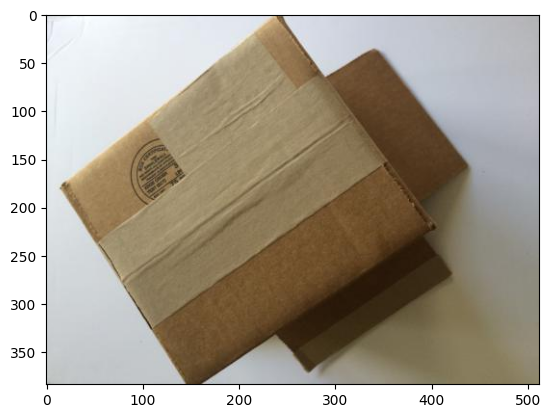

Sample Glass image:


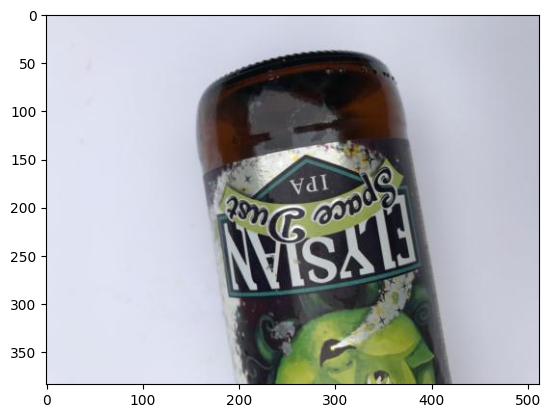

Sample Metal image:


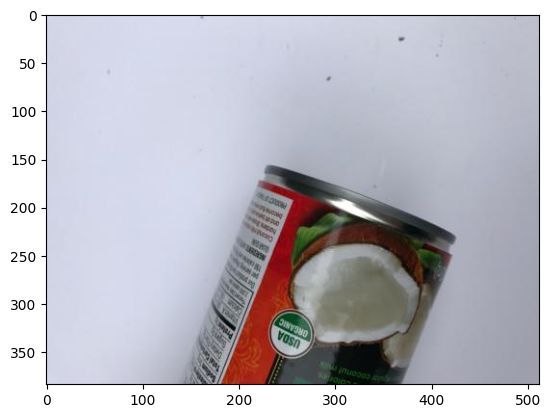

Sample Paper image:


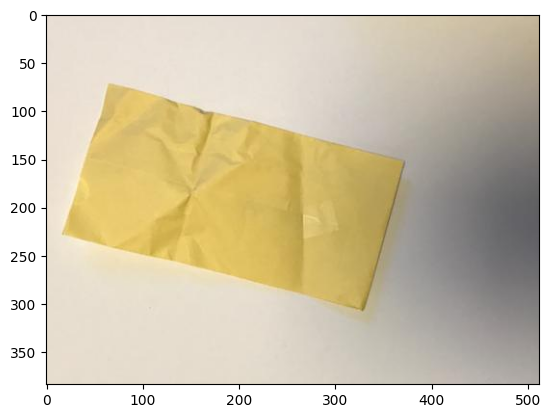

Sample Plastic image:


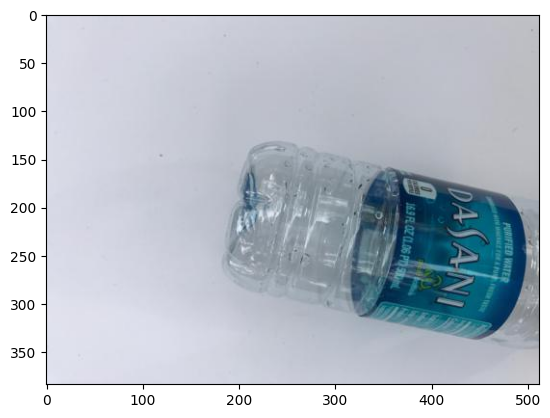

In [6]:
# Define directories for train, validation, and test sets
train_dir = './output/train'
val_dir = './output/val'
test_dir = './output/test'

# Function to display a sample image from a given directory and class
def display_sample_image(data_dir, class_name, title):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        return

    image_files = os.listdir(class_dir)
    if not image_files:
        print(f"No images found in {class_dir}")
        return

    image_path = os.path.join(class_dir, image_files[1])
    try:
        print(f"Sample {title} image:")
        plt.imshow(load_img(image_path))
        plt.show()
    except Exception as e:
        print(f"Error loading image: {e}")

# Display sample images
display_sample_image(train_dir, 'cardboard', 'Cardboard')
display_sample_image(train_dir, 'glass', 'Glass')
display_sample_image(train_dir, 'metal', 'Metal')
display_sample_image(train_dir, 'paper', 'Paper')
display_sample_image(train_dir, 'plastic', 'Plastic')



In [7]:
# Function to display a sample image size from a given directory and class
def check_image_size(data_dir, class_name):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        return

    image_files = os.listdir(class_dir)
    if not image_files:
        print(f"No images found in {class_dir}")
        return

    # Ensure there are enough images to access the 4th image
    if len(image_files) < 4:
        print(f"Not enough images in {class_dir} to access the 4th image.")
        return

    # Load the image and convert it into its numpy array representation
    sample_image = load_img(os.path.join(class_dir, image_files[3]))
    sample_array = img_to_array(sample_image)

    print(f"Each image has shape: {sample_array.shape}")

# Check image size for "plastic" class in the training set
check_image_size(train_dir, 'plastic')

Each image has shape: (384, 512, 3)


# Image Augmentation

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator( rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.3,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size= (192,256),
                                                      shuffle = True)

  validation_datagen = ImageDataGenerator(
                                          rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.3,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='categorical',
                                                                target_size=(192,256))

  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 1910 images belonging to 5 classes.
Found 238 images belonging to 5 classes.


# Transfer Learning


In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-06 13:08:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   167MB/s    in 0.5s    

2024-06-06 13:08:40 (167 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(192,256, 3))

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

In [13]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

#Callback


In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

# Get the Layer (Mixed4d)

In [15]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed4')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)


  return last_output

In [16]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 10, 14, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 10, 14, 768), dtype=tf.float32, name=None), name='mixed4/concat:0', description="created by layer 'mixed4'")


In [17]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


# Build Model


In [18]:
import tensorflow as tf
from tensorflow import keras

#def create_final_model(pre_trained_model ):
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense (256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense (5, activation='softmax')(x)
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

# Training Model

In [19]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 150,
                    steps_per_epoch=10,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/150
10/10 - 29s - loss: 2.4292 - accuracy: 0.3141 - val_loss: 1.6226 - val_accuracy: 0.2689 - 29s/epoch - 3s/step
Epoch 2/150
10/10 - 13s - loss: 1.4966 - accuracy: 0.3859 - val_loss: 1.2015 - val_accuracy: 0.5378 - 13s/epoch - 1s/step
Epoch 3/150
10/10 - 14s - loss: 1.2441 - accuracy: 0.4841 - val_loss: 1.1296 - val_accuracy: 0.5336 - 14s/epoch - 1s/step
Epoch 4/150
10/10 - 13s - loss: 1.1403 - accuracy: 0.5254 - val_loss: 1.0036 - val_accuracy: 0.6050 - 13s/epoch - 1s/step
Epoch 5/150
10/10 - 15s - loss: 1.0575 - accuracy: 0.5766 - val_loss: 0.9734 - val_accuracy: 0.5882 - 15s/epoch - 1s/step
Epoch 6/150
10/10 - 13s - loss: 1.0225 - accuracy: 0.5873 - val_loss: 0.9016 - val_accuracy: 0.6345 - 13s/epoch - 1s/step
Epoch 7/150
10/10 - 13s - loss: 0.9590 - accuracy: 0.6109 - val_loss: 0.8779 - val_accuracy: 0.6513 - 13s/epoch - 1s/step
Epoch 8/150
10/10 - 13s - loss: 0.9163 - accuracy: 0.6500 - val_loss: 0.8623 - val_accuracy: 0.6471 - 13s/epoch - 1s/step
Epoch 9/150
10/10 - 13s 

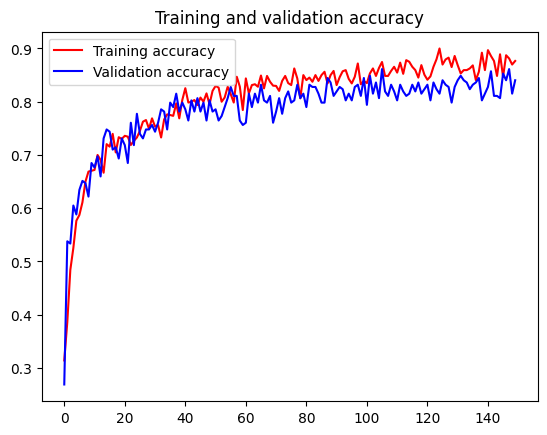

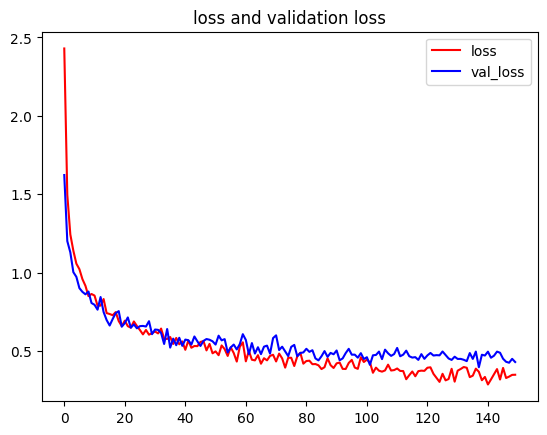

<Figure size 640x480 with 0 Axes>

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def test_generators(TEST_DIR, model):
    # Instantiate the ImageDataGenerator class for test data without augmentation
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load and preprocess the test data
    test_generator = test_datagen.flow_from_directory(
        directory=TEST_DIR,
        batch_size=64,
        class_mode='categorical',
        target_size=(192, 256)
    )

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

    print(f'Test loss: {loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

    return loss, accuracy


In [27]:
# Data Test
TEST_DIR = './output/test'

# Panggil fungsi test_generators untuk mengevaluasi model
test_loss, test_accuracy = test_generators(TEST_DIR, model2)

# Debug statement untuk memastikan nilai akurasi dan loss ditampilkan
print("Returned from test_generators function")
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


Found 242 images belonging to 5 classes.
3/3 [==============================] - 1s 168ms/step - loss: 0.2580 - accuracy: 0.8958
Test loss: 0.2580
Test accuracy: 0.8958
Returned from test_generators function
Test Loss: 0.25796690583229065
Test Accuracy: 0.8958333134651184


# Save Model

In [28]:
import tensorflow as tf

# Menyimpan model TensorFlow dalam format SavedModel
saved_model = 'saved_model'
tf.saved_model.save(model2, saved_model)


In [30]:
# Membuat konverter TFLite dari model yang disimpan
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)

# Mengoptimalkan model untuk ukuran
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Mengonversi model ke format TFLite
tflite_model = converter.convert()

# Menyimpan model TFLite ke dalam berkas
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)


In [29]:
# Menyimpan model dalam format HDF5
model2.save('/content/Model.save')

# Menyimpan arsitektur model dalam format JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Menyimpan bobot (weights) model dalam format HDF5
model2.save_weights("model.h5")
